In [1]:
import warnings

warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool, metrics, EFeaturesSelectionAlgorithm
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import umap.umap_ as umap
import shap

from pandarallel import pandarallel
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # to manipulate x-tickers
import plotly.express as px
import seaborn as sns

from collections import Counter
from tqdm import tqdm
import warnings
import logging
import random
import pickle
import json
import os

from IPython.core.interactiveshell import InteractiveShell

# from samolet_parking_lot.modules.cv import *
from samolet_parking_lot.modules.feature_engineering import *
from samolet_parking_lot.modules.features_selection import *
from samolet_parking_lot.modules.hyperparam_tuning import *
from samolet_parking_lot.modules.model import *
from samolet_parking_lot.modules.utils import *

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

sns.set(rc={'figure.figsize': (20, 10), 'figure.facecolor': 'white'})
sns.set_palette("viridis")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # activate parallelism
pandarallel.initialize(progress_bar=True)
InteractiveShell.ast_node_interactivity = "all"  # show all outputs, not only the last
seed_everything()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Stage 1. Data Preparation

In [2]:
data = pd.read_csv("../data/raw/train_dataset_Самолет.csv")

In [3]:
data = create_date_features(data)

In [4]:
# drop columns with big share of missing values
not_null_columns_names = get_not_null_columns_names(data, threshold=.999)
# X_train = X_train[null_columns_names]
data_for_split = data[not_null_columns_names]

In [5]:
# def target_rate_improvements(data, subjects, extra):
#     """Compute the improvement in squared difference between the positive rate in each fold vs the overall positive rate in the dataset"""
#     target_rate = data['target'].mean()
#     rate_without_extra = data.loc[lambda d: d['client_id'].isin(subjects), 'target'].mean()
#     rate_with_extra =  data.loc[lambda d: d['client_id'].isin(subjects + [extra]), 'target'].mean()
#     rate_without_extra = 0 if np.isnan(rate_without_extra) else rate_without_extra
# 
#     return (rate_without_extra - target_rate)**2 - (rate_with_extra - target_rate)**2
# 
# 
# def size_improvement(data, subjects, n_folds):
#     """compute the improvement in squared difference between the number of observations in each fold vs the expected number of observations"""
#     target_obs_per_fold = len(data) / n_folds
# 
#     return [(target_obs_per_fold - len(data.loc[lambda d: d['client_id'].isin(subject)])) ** 2 for subject in subjects.values()]
# 
# n_folds = 5
# test_subjects_per_fold = {fold: [] for fold in range(n_folds)}
# subjects_to_assign = list(range(100))
# 
# for subject in tqdm(data['client_id'].unique()):
#     target_rate_improvement = np.array([target_rate_improvements(data, test_subjects_per_fold[fold], subject) for fold in range(n_folds)])
#     size_improvements = np.array(size_improvement(data, test_subjects_per_fold, n_folds)) * 0.001
#     best_fold = np.argmax(target_rate_improvement +size_improvements)
#     test_subjects_per_fold[best_fold] += [subject]

In [6]:
# for fold, subjects in test_subjects_per_fold.items():
#     print('-'*80)
#     print(f'for fold {fold}')
#     test_data = data.loc[lambda d: d['client_id'].isin(subjects)]
#     train_data = data.loc[lambda d: ~d['client_id'].isin(subjects)]
# 
#     print('train - pos rate:', train_data['target'].mean(), 'size:', len(train_data))
#     print('test - pos rate:', test_data['target'].mean(), 'size:', len(test_data))

In [7]:
# split on train, valid, test with client_id being only withing one split
X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_valid_test_split(data_for_split)  # fix potential problem (connected to first getting non_null columns, and then removing target, client_id, date) if time will be

In [ ]:
X = pd.concat([X_train, X_valid, X_test], ignore_index=True)
y = pd.concat([y_train, y_valid, y_test], ignore_index=True)

# Stage 2. Data Analysis

### Data Inspection

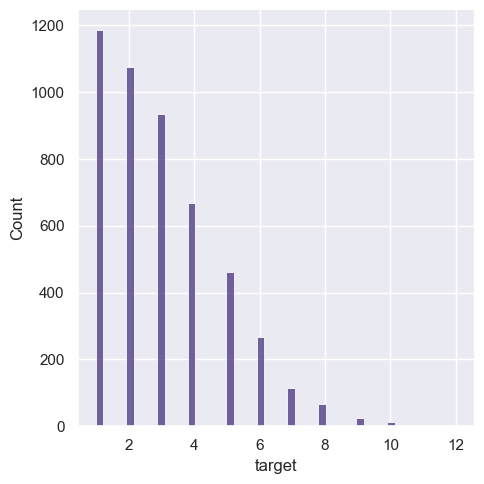

In [8]:
# Qnt of entries per client_id
plt_data = data[['client_id', 'target']].groupby('client_id', as_index=True)['target'].count()
ax = sns.displot(plt_data)
plt.show()

In [9]:
plt_data = (
    data[['client_id', 'target']]
    .groupby('client_id', as_index=True)
    .agg(qnt=('target', 'count'),
         sum=('target', 'sum'))
)
plt_data['success_share'] = plt_data['sum'] / plt_data['qnt']

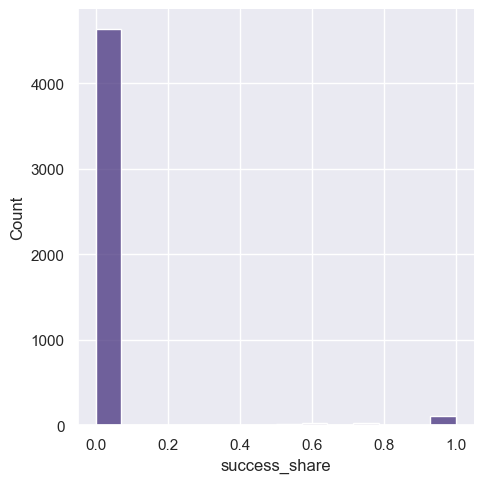

In [10]:
# distribution of share of successful events per client
ax = sns.displot(plt_data.success_share)
plt.show()

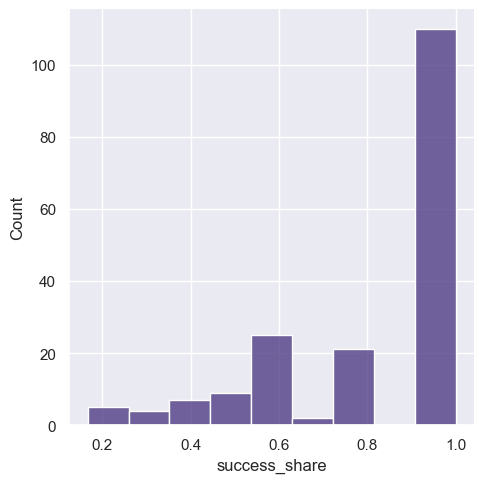

In [11]:
# distribution of share of successful events per client (w/o 0%) (among those who purchases parking lot)
ax = sns.displot(plt_data.query("success_share > 0").success_share)
plt.show()

In [12]:
# share of clents with 1
(
    data[['client_id', 'target']]
    .groupby('target', as_index=True)
    .agg(qnt=('client_id', 'count'))
)

,qnt
target,
0,14020
1,436


### Plot Possible Clusters

In [13]:
data_umap = data[data.select_dtypes(include=['float64', 'int64']).columns].fillna(0)
data_umap = StandardScaler().fit_transform(data_umap)

In [14]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data_umap)
embedding.shape

(14456, 2)

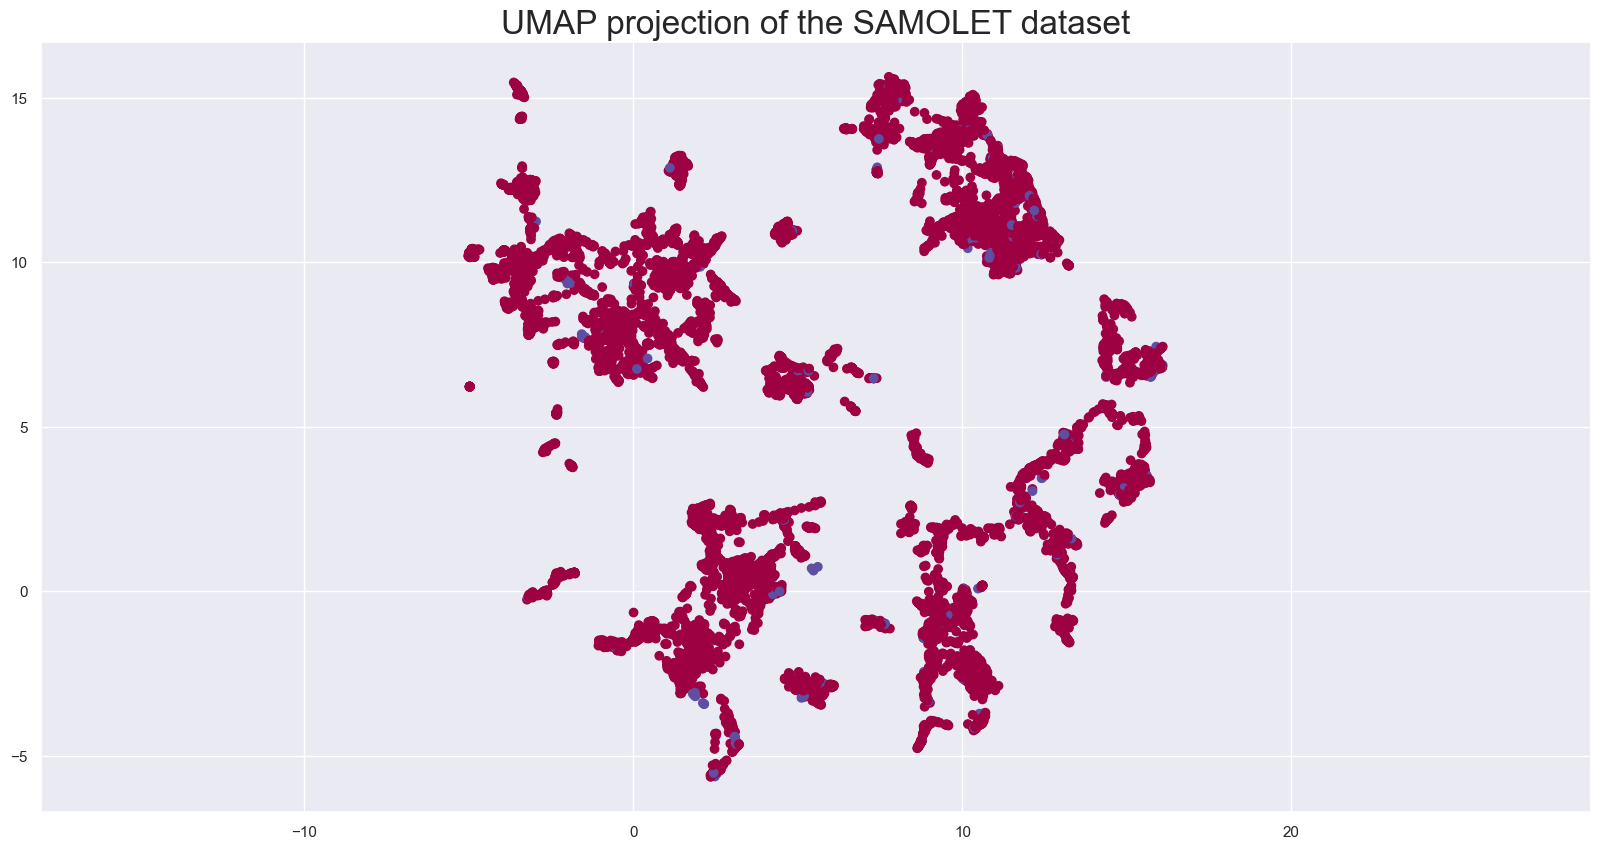

In [15]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=data.target,
    cmap='Spectral',
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the SAMOLET dataset', fontsize=24);

### Dimensionality Reduction

In [16]:
data_umap = X_train[X_train.select_dtypes(include=['float64', 'int64']).columns].fillna(0)
data_umap = StandardScaler().fit_transform(data_umap)

In [17]:
reducer = umap.UMAP(n_components=50)
umap_embedding = reducer.fit_transform(data_umap)

In [18]:
pca = PCA(n_components=400, svd_solver='full')
pca_embedding = pca.fit_transform(data_umap)

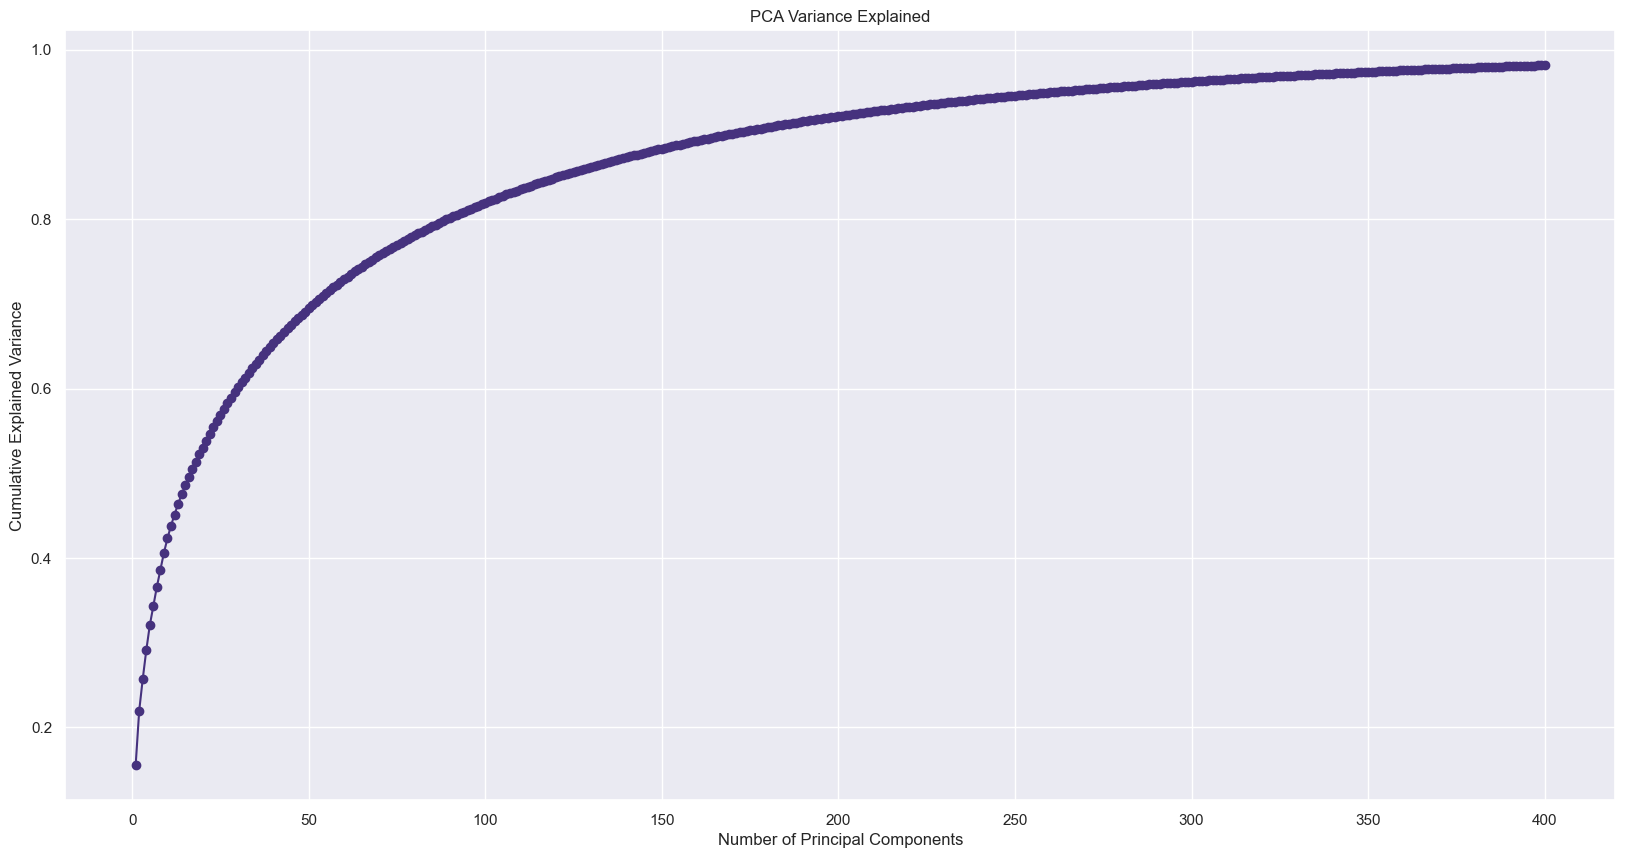

Plot was saved to PCA_varian_without_UMAP


<Figure size 2000x1000 with 0 Axes>

In [19]:
plot_pca_variance(pca, save_to="PCA_varian_without_UMAP")

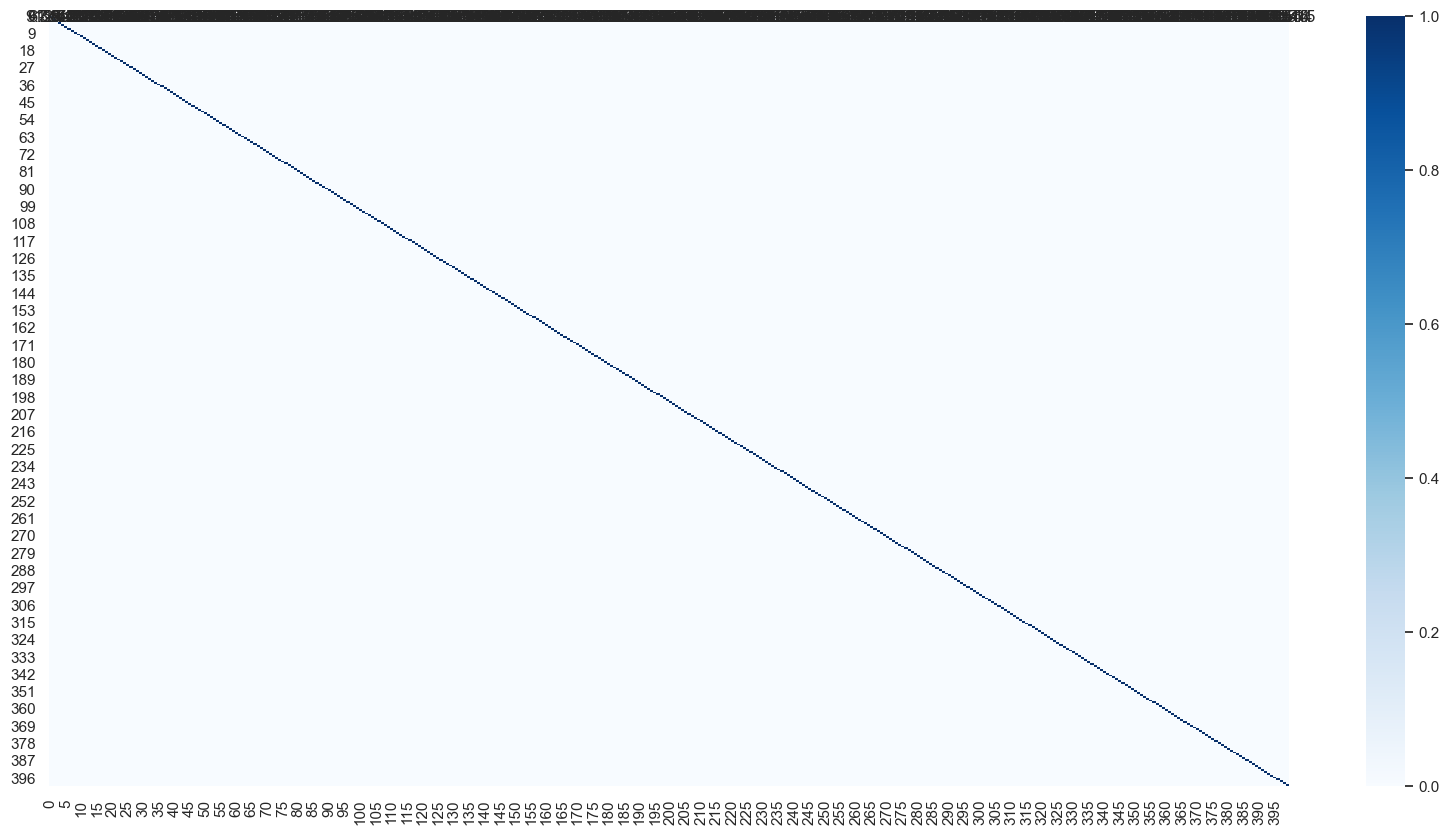

In [20]:
ax = sns.heatmap(pd.DataFrame(pca_embedding).corr(), annot=True, cmap='Blues')
plt.show()

# Stage 3. Model (w/o Feature Selection)

In [21]:
model = catboost_model_classifier(X_train, X_valid, y_train, y_valid)
y_pred = model.predict(X_test)
roc_auc_score(y_test, y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8719916502946956

ROC-AUC score is:  0.8719916502946956


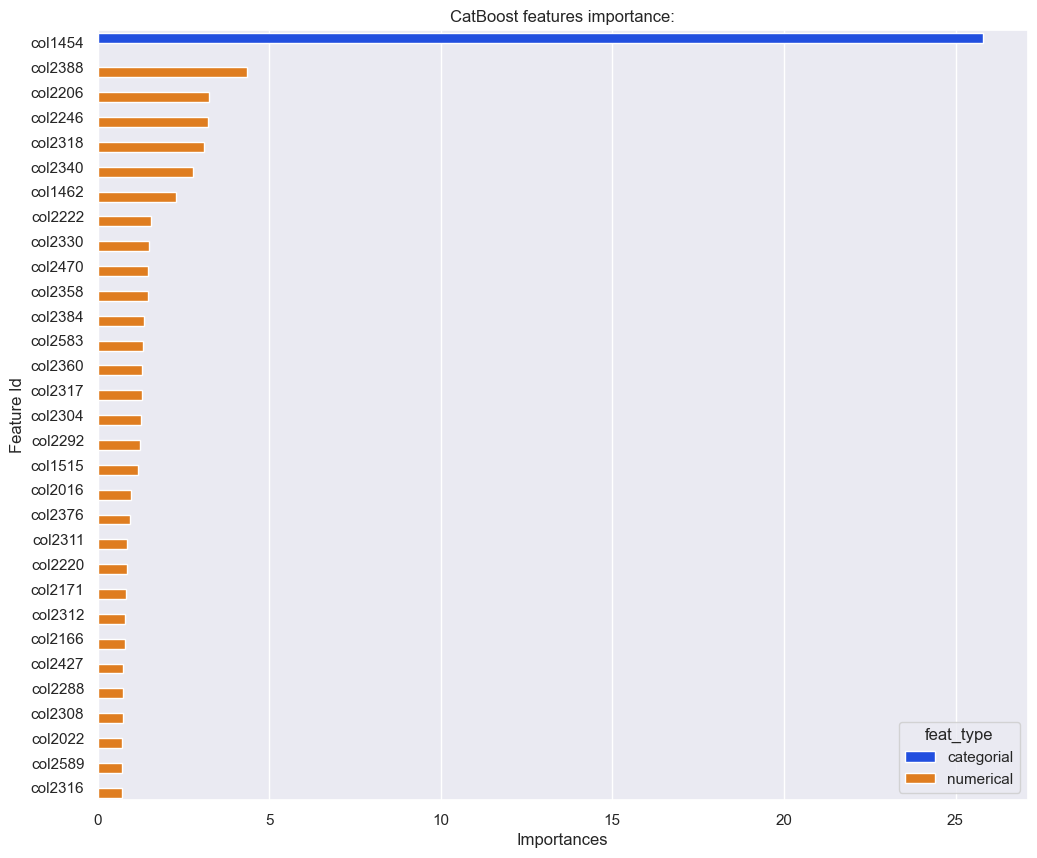

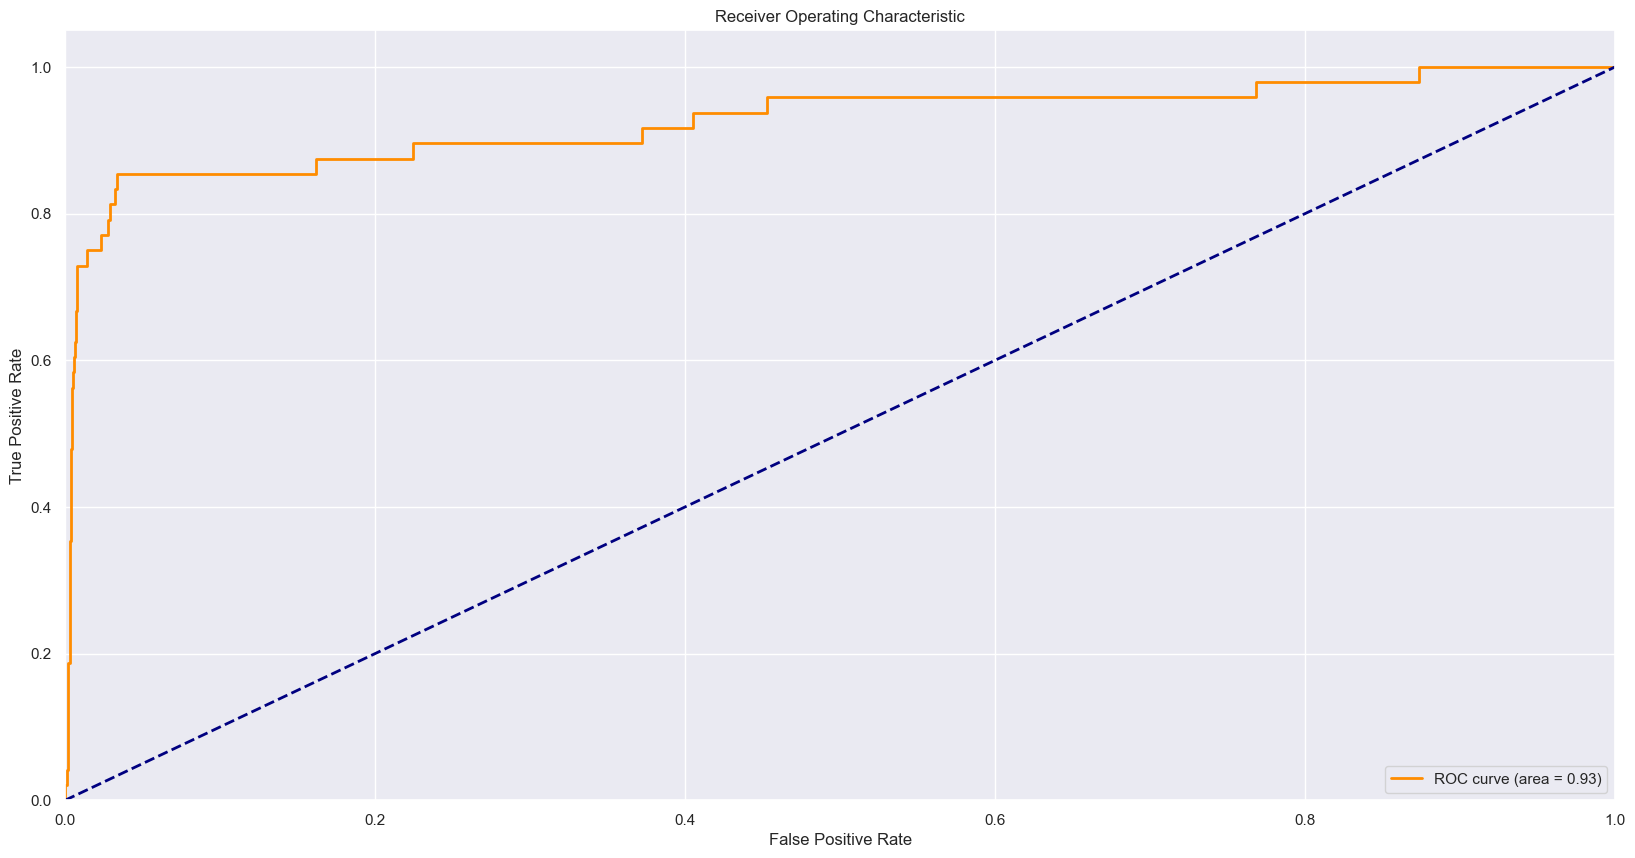

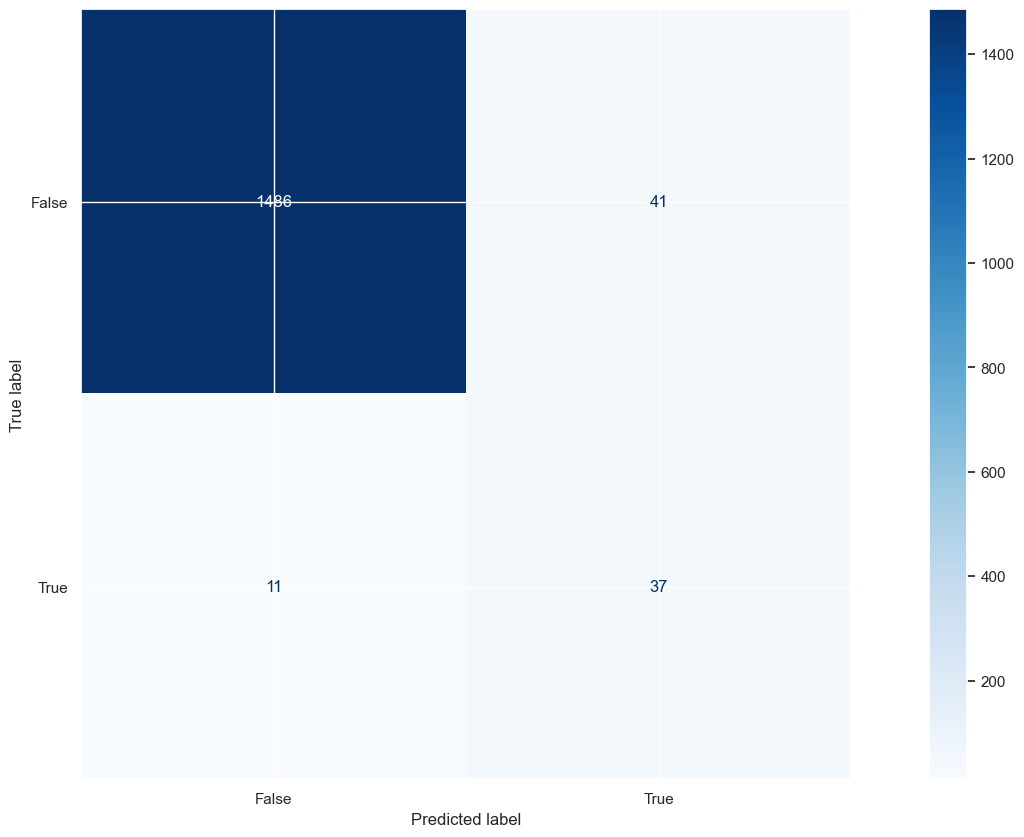

In [22]:
plot_model_info(model, X_test, y_test)  #categorical_columns

# Step 4. Feature Selection

In [23]:
useful_column_indices_sk = get_sklearn_important_features(model, X_train, X_test, y_test, plot=False)
useful_column_indices_rf = get_random_feat_important_features(X_train, y_train, X_valid, y_valid)
useful_column_indices_union = list(set(useful_column_indices_sk + useful_column_indices_rf))
useful_column_indices_intersect = lists_intersection(useful_column_indices_sk, useful_column_indices_rf)

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
2023-09-10 00:03:58,193 INFO From 2407 feature 64 were selected (0.03%).Share of 'Object' type features is: 0.00%
100%|██████████| 10/10 [03:09<00:00, 18.98s/it]
2023-09-10 00:07:08,036 INFO From 2408 feature 164 were selected (0.07%).Share of 'Object' type features is: 0.00%.Set Threshold is 0.05785824037325406


In [38]:
# with open('useful_column_indices_sk.pkl', 'wb') as fp:
#     pickle.dump(useful_column_indices_sk, fp)
# with open('useful_column_indices_rf.pkl', 'wb') as fp:
#     pickle.dump(useful_column_indices_rf, fp)

In [39]:
shrunk_columns_anew = False
if shrunk_columns_anew:
    useful_column_indices_sk = get_sklearn_important_features(model, X_train, X_test, y_test, plot=False)
    useful_column_indices_rf = get_random_feat_important_features(X_train, y_train, X_valid, y_valid)
else:
    with open('useful_column_indices_sk.pkl', 'rb') as fp:
        useful_column_indices_sk = pickle.load(fp)
    with open('useful_column_indices_rf.pkl', 'rb') as fp:
        useful_column_indices_rf = pickle.load(fp)

In [41]:
# compare both feature extraction methods
lists_analysis(useful_column_indices_sk, useful_column_indices_rf)

{'intersection': {'absolute': 15, 'percent': 7.04},
 'difference_list1': {'absolute': 49, 'percent': 23.0},
 'difference_list2': {'absolute': 149, 'percent': 69.95}}

In [42]:
useful_column_indices = useful_column_indices_sk
X_train_cleaned = X_train.iloc[:, useful_column_indices]
X_valid_cleaned = X_valid.iloc[:, useful_column_indices]
X_test_cleaned = X_test.iloc[:, useful_column_indices]

In [43]:
model_cleansed = catboost_model_classifier(
    X_train_cleaned,
    X_valid_cleaned,
    y_train, y_valid
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

ROC-AUC score is:  0.9032416502946955


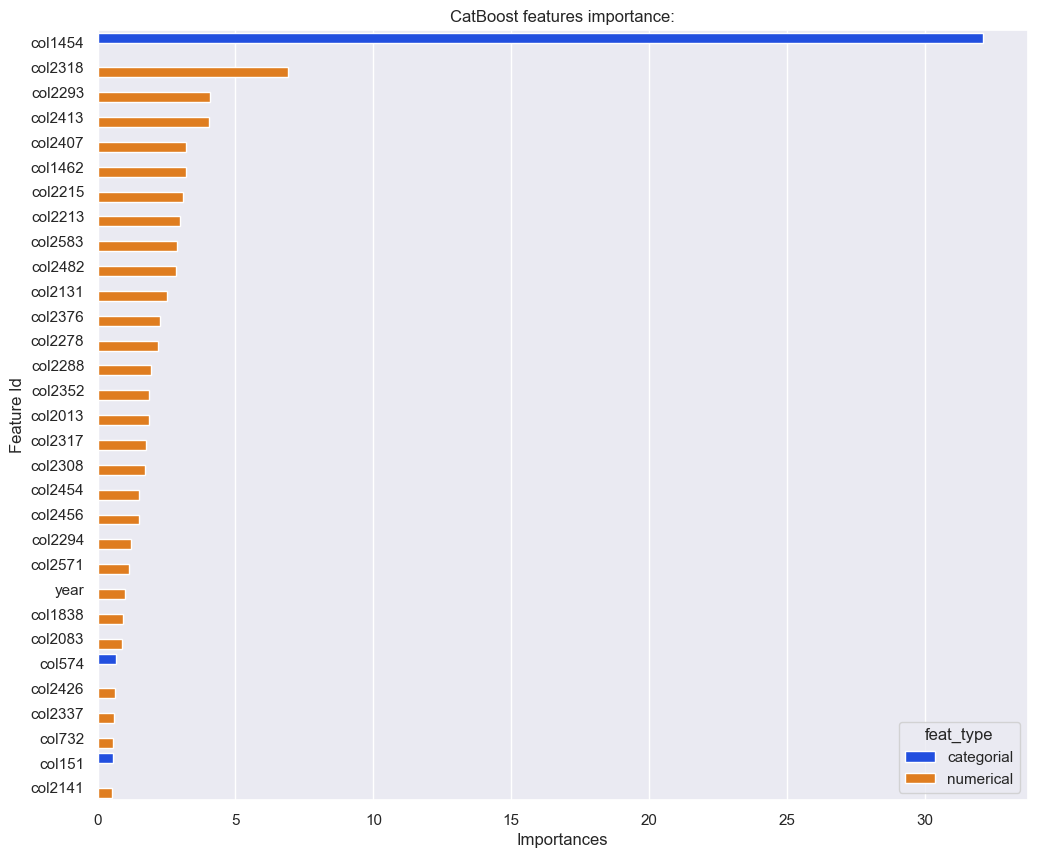

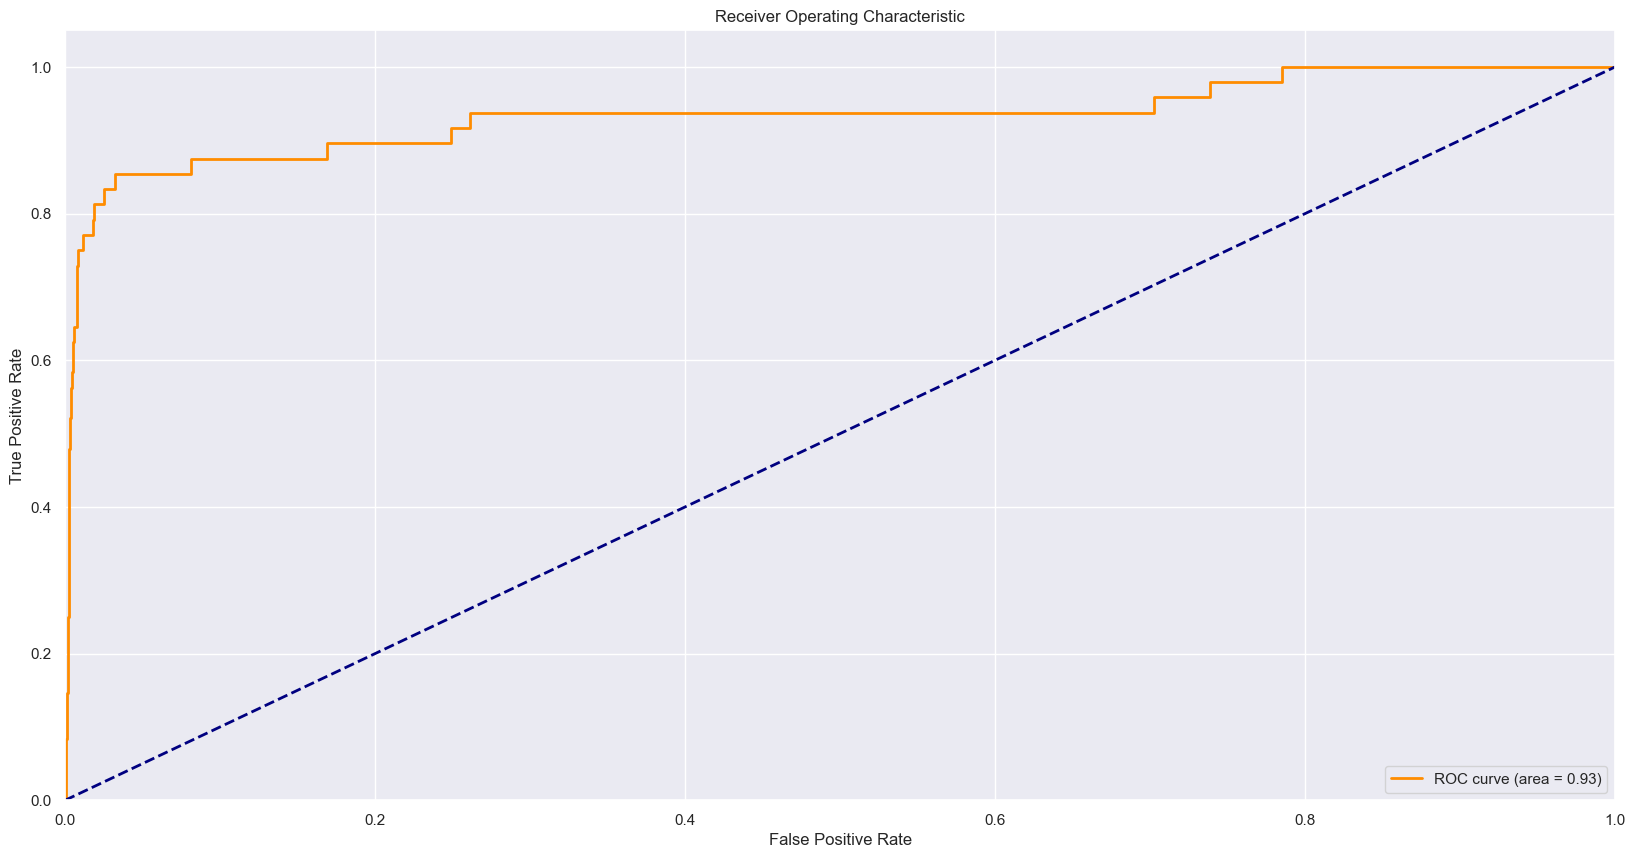

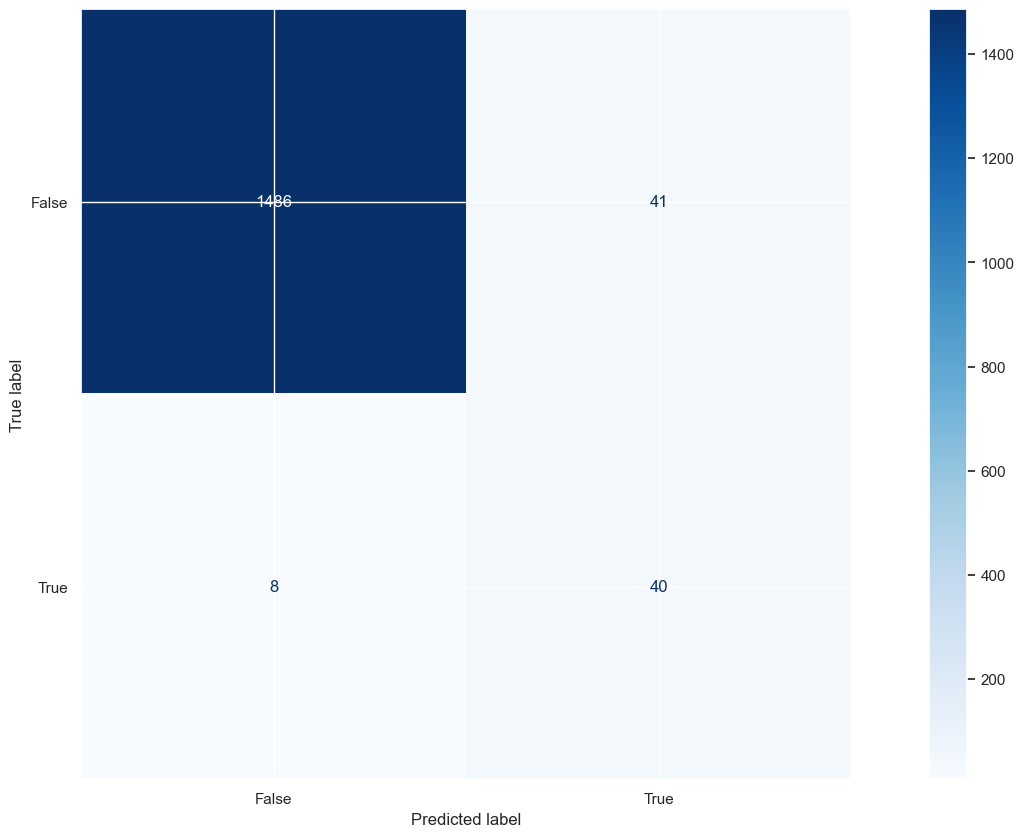

In [44]:
plot_model_info(
    model_cleansed,
    X_test_cleaned,
    y_test,
)

# Step 5. Hyperparameters Tuning

In [45]:
search_new_params = False
if search_new_params:
    hyperparams = search_best_params(X_train_cleaned, X_valid_cleaned, y_train, y_valid, max_evals=300)
else:
    with open('best_hyperparams_full_dataset.pkl', 'rb') as fp:
        hyperparams = pickle.load(fp)

In [46]:
# with open('best_hyperparams_full_dataset.pkl', 'wb') as fp:
#     pickle.dump(hyperparams, fp)

In [47]:
params = {
    'learning_rate': hyperparams['learning_rate'],
    'iterations': hyperparams['iterations'],
    'depth': hyperparams['depth'],
    'loss_function': 'Logloss',
    'l2_leaf_reg': hyperparams['l2_leaf_reg'],
    'eval_metric': 'Logloss',
    'early_stopping_rounds': 20,
    'random_seed': 42,
    'auto_class_weights': "Balanced",
}

In [48]:
categorical_columns = X_train_cleaned.select_dtypes(exclude=['float64', 'int64']).columns.to_list()
model_best = CatBoostClassifier(**params)
model_best.fit(
    X=X_train_cleaned,
    y=y_train,
    eval_set=(X_valid_cleaned, y_valid),
    verbose=250,
    cat_features=categorical_columns
)

0:	learn: 0.5170192	test: 0.4607927	best: 0.4607927 (0)	total: 6.01ms	remaining: 854ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2915646436
bestIteration = 10

Shrink model to first 11 iterations.


In [49]:
# model_best.save_model('best_model')

ROC-AUC score is:  0.9175261951538967


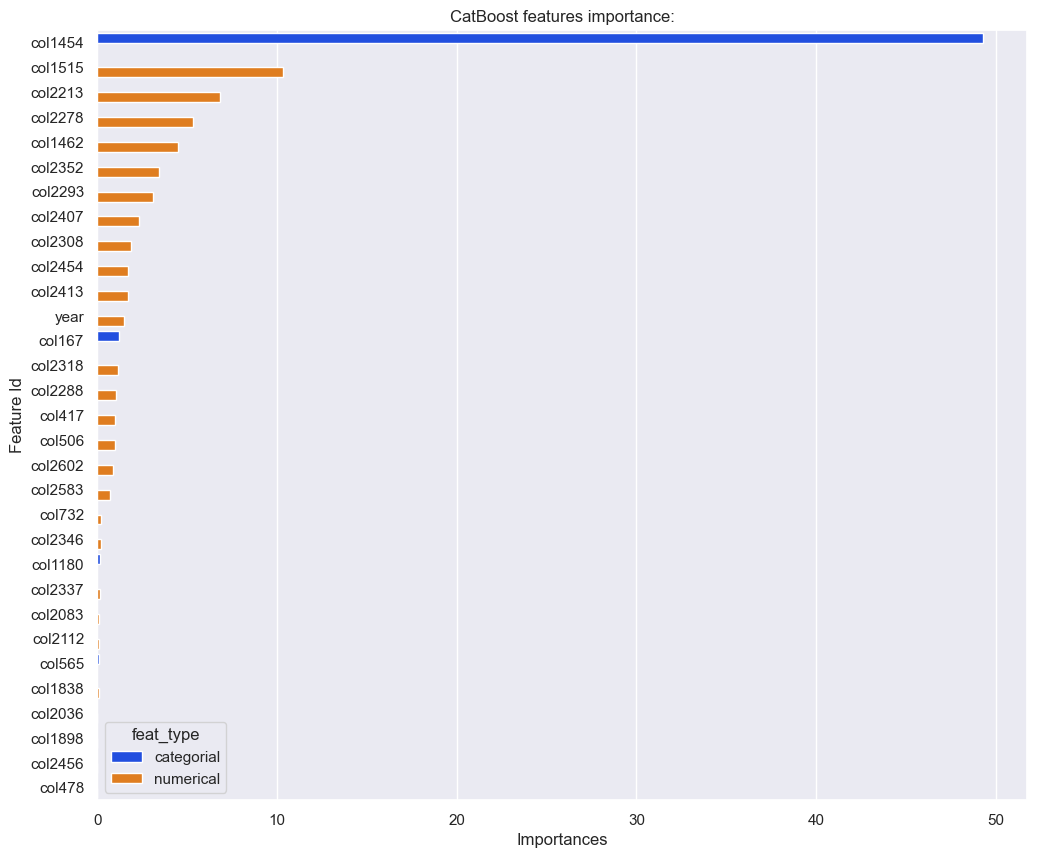

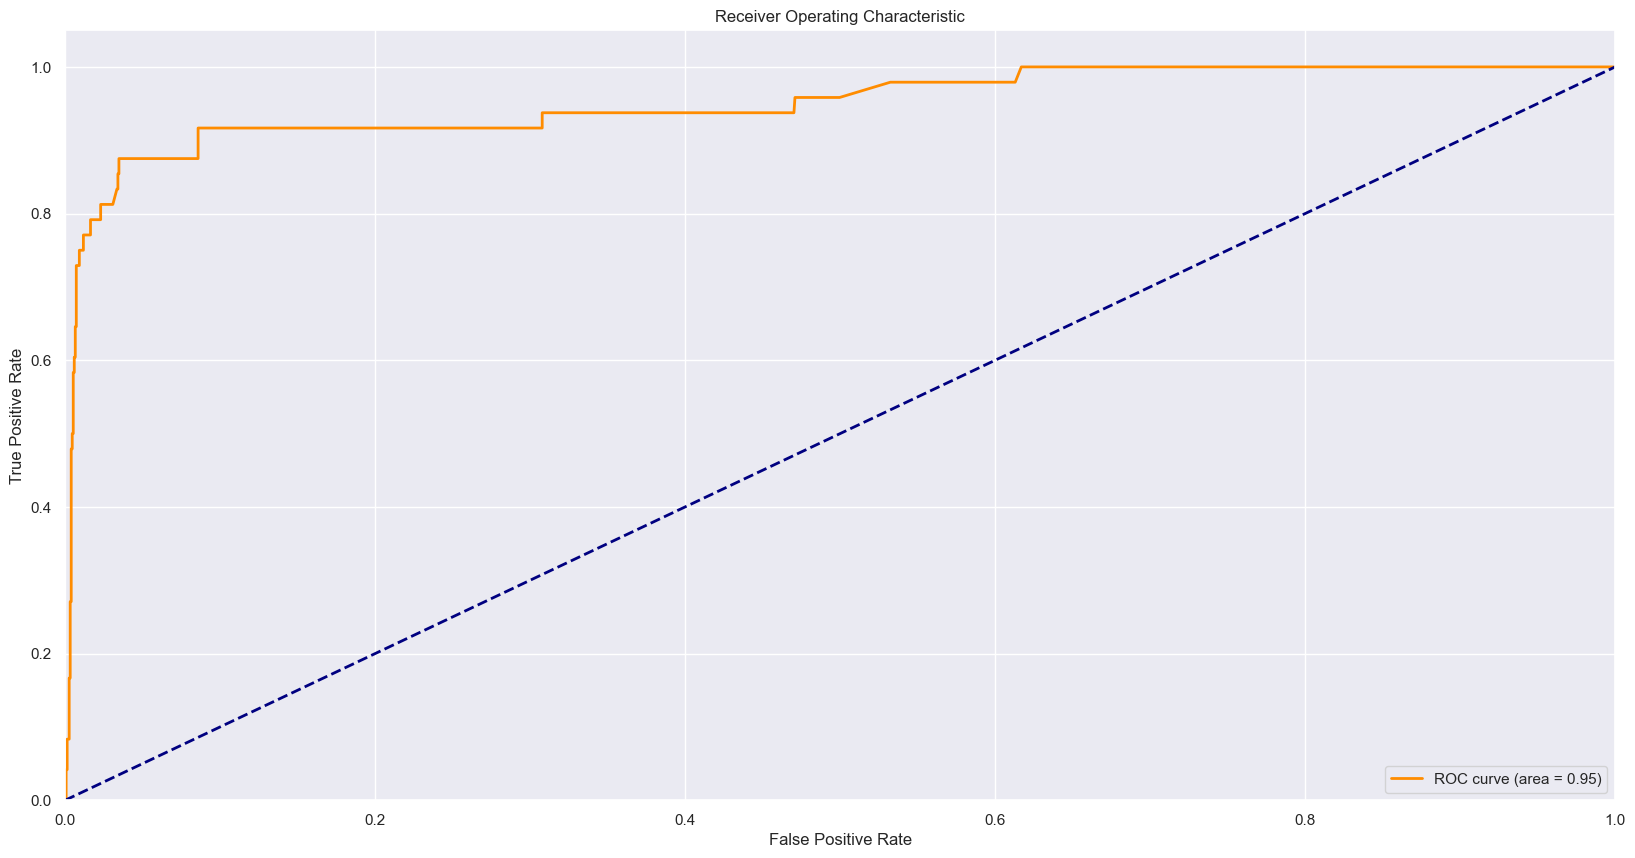

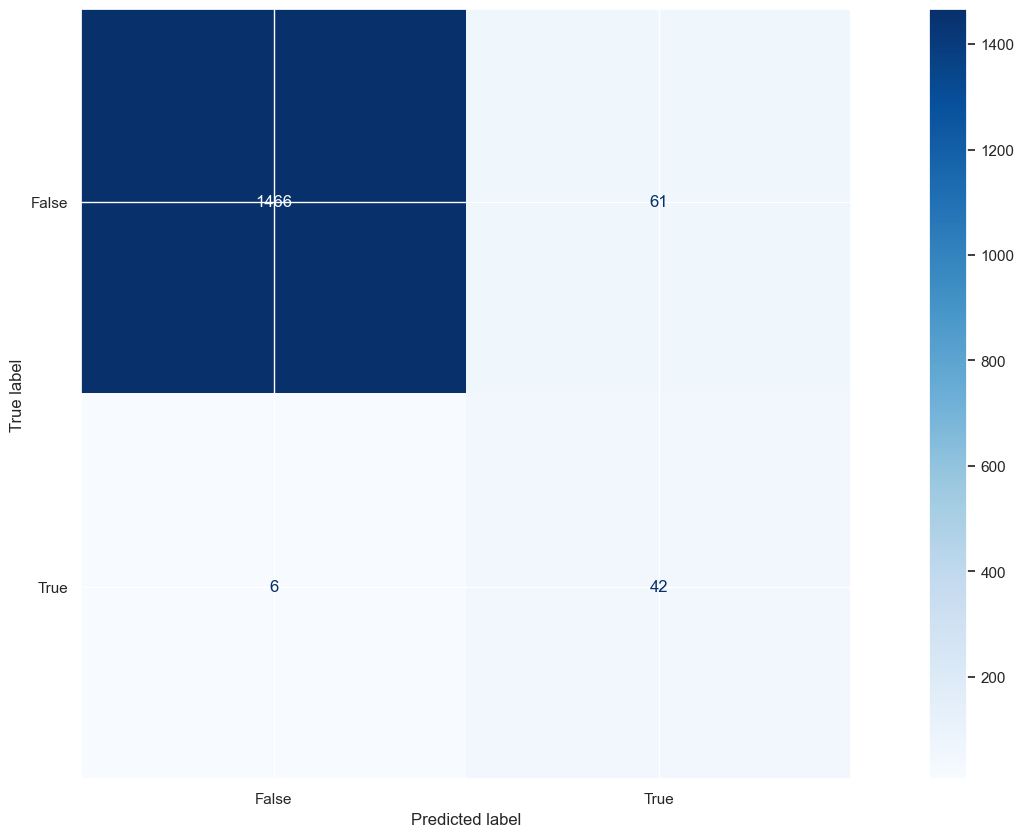

In [50]:
plot_model_info(
    model_best,
    X_test_cleaned,
    y_test,
)

# Step 6. Add Logistic Regression

In [51]:
preprocessor = get_transformer_data_for_regression(X_train_cleaned)

In [52]:
X_train_linear = preprocessor.transform(X_train_cleaned)
X_test_linear = preprocessor.transform(X_test_cleaned)

PCA(n_components=64, svd_solver='full')

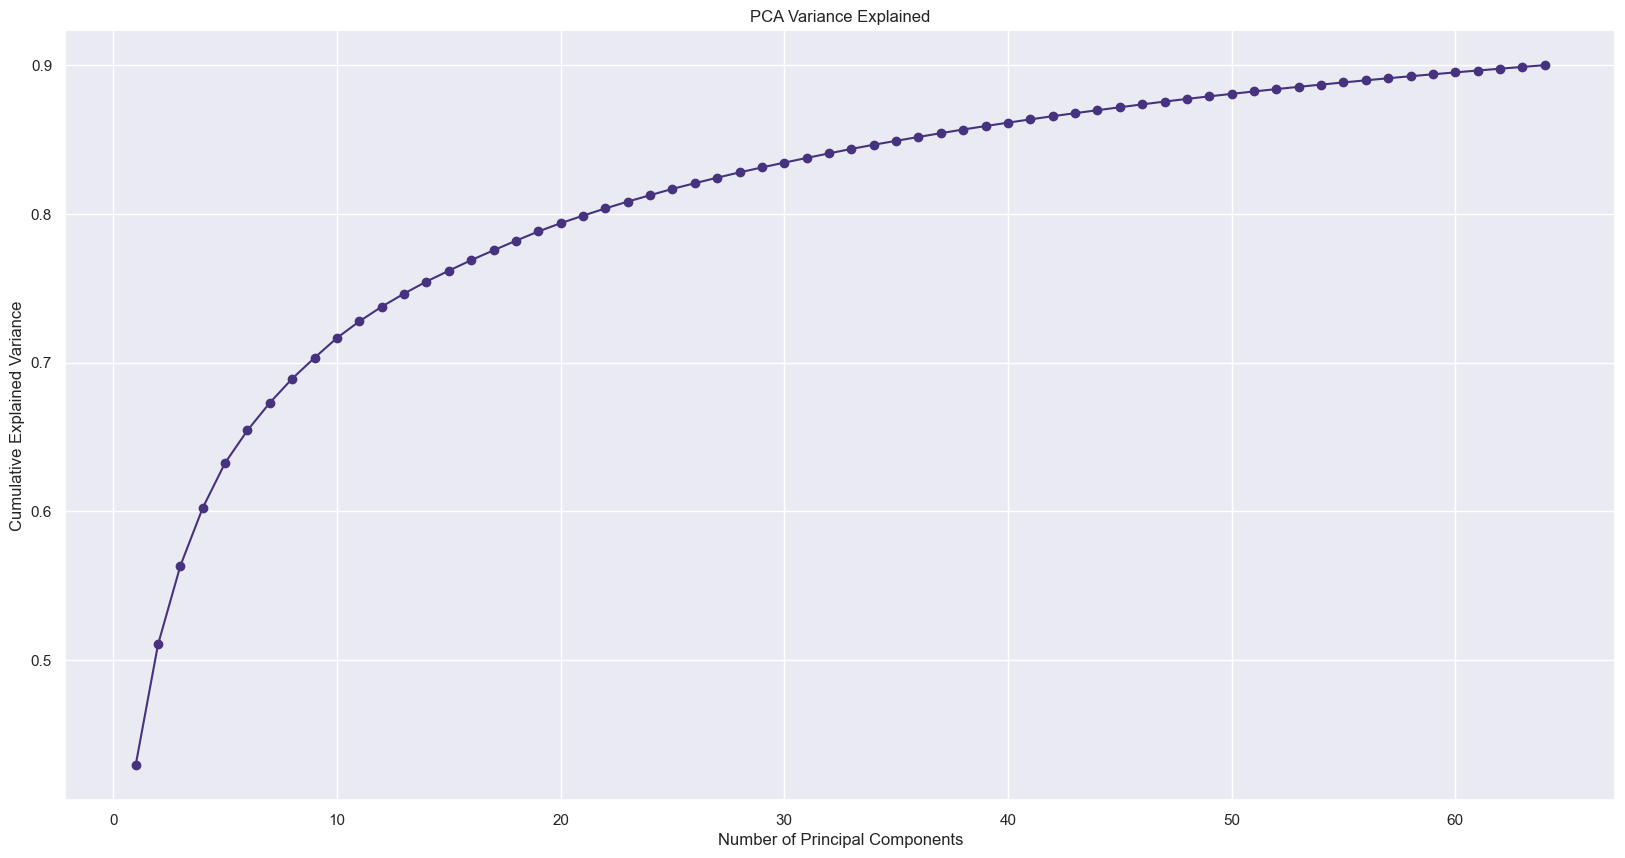

In [53]:
pca = PCA(n_components=min(100, len(X_train_cleaned.columns)), svd_solver='full')
pca.fit(X_train_linear)
plot_pca_variance(pca)

In [54]:
top_n = 60
train_pca = pca.fit_transform(X_train_linear)[:, :top_n]  # we select only top N features
test_pca = pca.transform(X_test_linear)[:, :top_n]

### LogisticRegression

In [55]:
logreg = LogisticRegression(random_state=42, class_weight='balanced', n_jobs=10)
logreg.fit(train_pca, y_train)

/Users/filin_va/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', n_jobs=10, random_state=42)

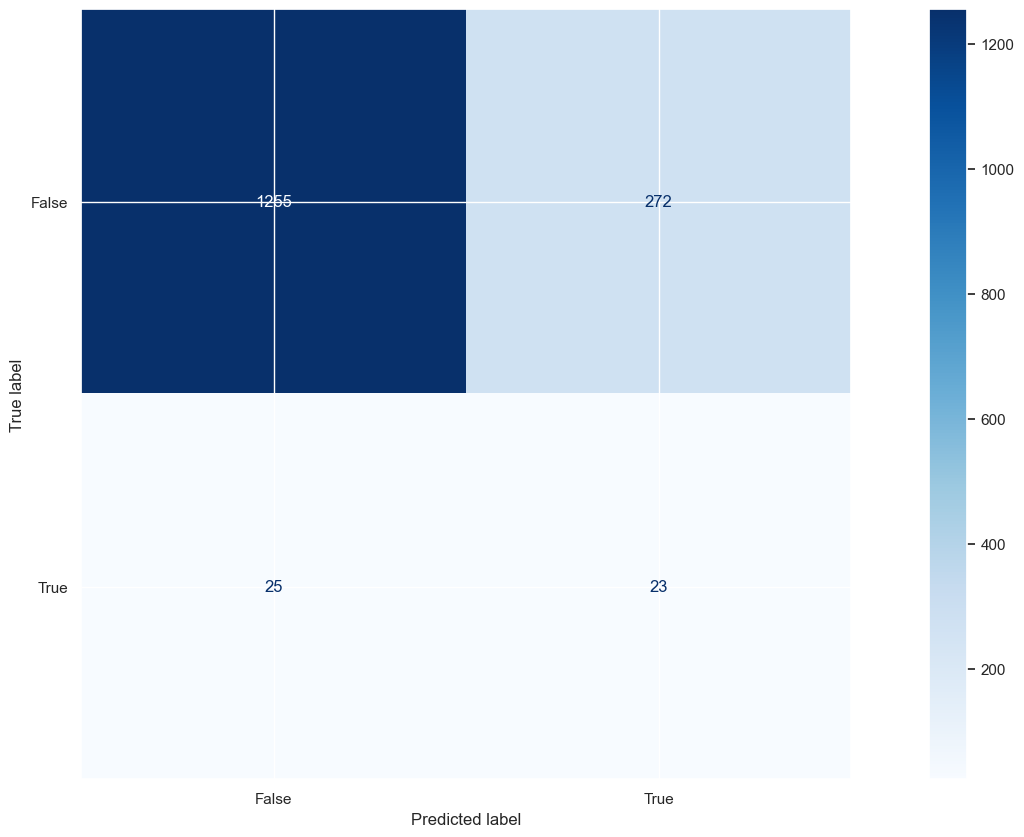

In [56]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, logreg.predict(test_pca)), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

### LogisticRegressionCV

In [57]:
logreg_cv = LogisticRegressionCV(cv=5, random_state=42, class_weight='balanced', penalty='l2', n_jobs=10)
logreg_cv.fit(train_pca, y_train)

/Users/filin_va/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/filin_va/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

LogisticRegressionCV(class_weight='balanced', cv=5, n_jobs=10, random_state=42)

ROC-AUC score is:  0.6196586444007858


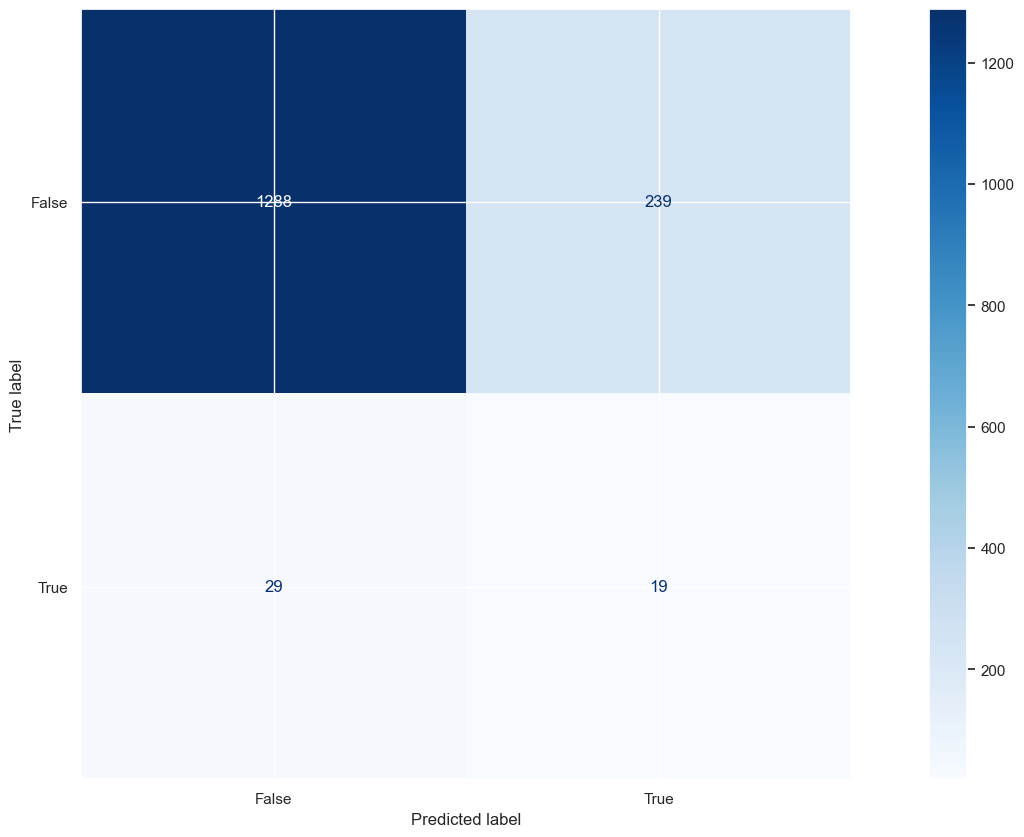

In [58]:
print("ROC-AUC score is: ", roc_auc_score(y_test, logreg_cv.predict(test_pca)))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, logreg_cv.predict(test_pca)), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

# Step 7. CV

In [ ]:
# from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, early_stop
# from catboost import CatBoostClassifier, cv, Pool
# 
# 
# def search_best_params_cv(
#         X_train, X_val, y_train, y_val, max_evals=100, early_stop_steps=50
# ):
#     def objective(space):
#         # Modify the parameters to be used in CatBoost
# 
#         # Perform cross-validation and return the average AUC
#         params = {
#             "learning_rate": space["learning_rate"],
#             "iterations": int(space["iterations"]),
#             "l2_leaf_reg": space["l2_leaf_reg"],
#             "depth": space["depth"],
#             "random_strength": space["random_strength"],
#             "border_count": space["border_count"],
#             "bagging_temperature": space["bagging_temperature"],
#             "loss_function": "Logloss",
#             "random_seed": 42,
#             "logging_level": "Silent",
#             "auto_class_weights": "Balanced",
#             "early_stopping_rounds": 20,
#         }
#         cv_results = cv(pool, params, fold_count=5)
#         avg_auc = np.mean(cv_results["test-Logloss-mean"])
#         return {"loss": avg_auc, "status": STATUS_OK}
# 
#     # Get categorical and numerical columns
#     categorical_columns = X_train.select_dtypes(exclude=["float64", "int64"]).columns
#     numerical_columns = X_train.select_dtypes(include=["float64", "int64"]).columns
# 
#     # Fill NA values and convert data types
#     X_train[numerical_columns] = X_train[numerical_columns].fillna(0).astype(int)
#     X_train[categorical_columns] = X_train[categorical_columns].astype(str)
# 
#     # Create a Pool object
#     global pool
#     pool = Pool(X_train, y_train, cat_features=categorical_columns.to_list())
# 
#     # Define the hyperparameter space
#     search_space = {
#         "learning_rate": hp.uniform("learning_rate", 0.1, 0.5),
#         "iterations": hp.randint("iterations", 100, 500),
#         "l2_leaf_reg": hp.randint("l2_leaf_reg", 1, 10),
#         "depth": hp.randint("depth", 4, 10),
#         "random_strength": hp.choice("random_strength", (0.0, 1.0)),
#         "border_count": hp.qloguniform("border_count", np.log(32), np.log(255), 1),
#         "bagging_temperature": hp.loguniform(
#             "bagging_temperature", np.log(1), np.log(3)
#         ),
#     }
# 
#     # Run the hyperparameter optimization
#     trials = Trials()
#     best = fmin(objective, search_space, algo=tpe.suggest, max_evals=50, trials=trials)
# 
#     # Train the final model on the entire dataset with the best found parameters
#     best_params = {
#         "learning_rate": best["learning_rate"],
#         "iterations": int(best["iterations"]),
#         "l2_leaf_reg": best["l2_leaf_reg"],
#         "depth": best["depth"],
#         "random_strength": best["random_strength"],
#         "border_count": best["border_count"],
#         "bagging_temperature": best["bagging_temperature"],
#         "loss_function": "Logloss",
#         "random_seed": 42,
#         "logging_level": "Silent",
#         "auto_class_weights": "Balanced",
#         "early_stopping_rounds": 20,
#     }
#     model = CatBoostClassifier(**best_params)
# 
#     model.fit(
#         X_train,
#         y_train,
#         eval_set=(X_val, y_val),
#         cat_features=categorical_columns.to_list(),
#         plot=True,
#         verbose=False,
#     )
# 
#     # # Make predictions on the test set
#     # X_test[numerical_columns] = X_test[numerical_columns].fillna(0).astype(int)
#     # X_test[categorical_columns] = X_test[categorical_columns].astype(str)
#     # predictions = model.predict(X_test)
# 
#     return best_params

In [65]:
X_cleaned = pd.concat([X_train_cleaned, X_valid_cleaned, X_test_cleaned], ignore_index=True)
y = pd.concat([y_train, y_valid, y_test], ignore_index=True)
best_params = search_best_params_cv(X_cleaned, y, max_evals=100)

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

2023-09-10 00:13:21,829 INFO build_posterior_wrapper took 0.000322 seconds
2023-09-10 00:13:21,829 INFO TPE using 0 trials


 50%|█████     | 1/2 [00:12<00:12, 12.10s/trial, best loss: 0.21660966730434675]

2023-09-10 00:13:33,929 INFO build_posterior_wrapper took 0.000290 seconds
2023-09-10 00:13:33,930 INFO TPE using 1/1 trials with best loss 0.216610


100%|██████████| 2/2 [00:14<00:00,  7.48s/trial, best loss: 0.21660966730434675]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [66]:
categorical_columns = X_train_cleaned.select_dtypes(exclude=['float64', 'int64']).columns.to_list()
model_best_cv = CatBoostClassifier(**best_params)
model_best_cv.fit(
    X=X_train_cleaned,
    y=y_train,
    eval_set=(X_valid_cleaned, y_valid),
    verbose=250,
    cat_features=categorical_columns
)

In [69]:
# model_best_cv.save_model('model_best_cv_2')

ROC-AUC score is:  0.9175261951538967


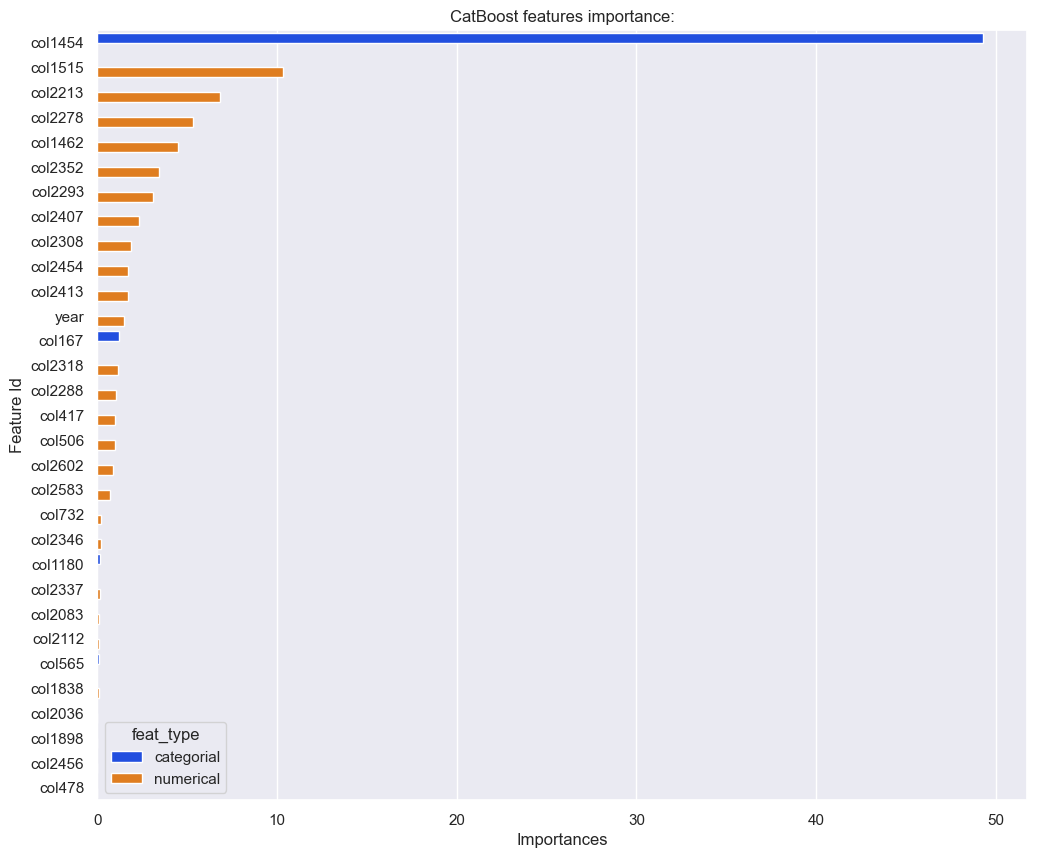

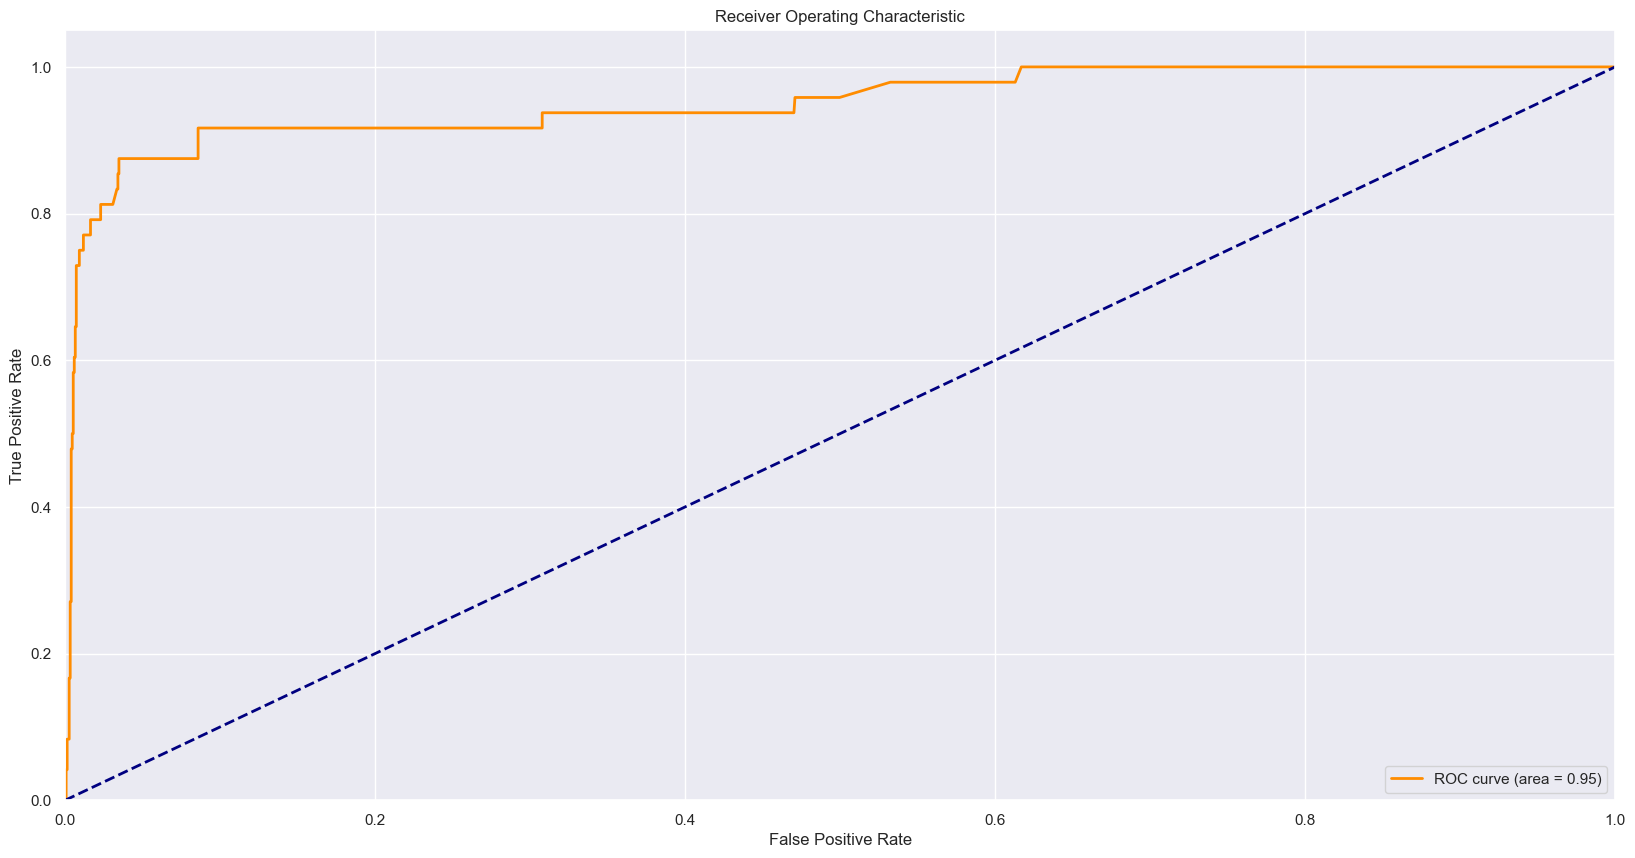

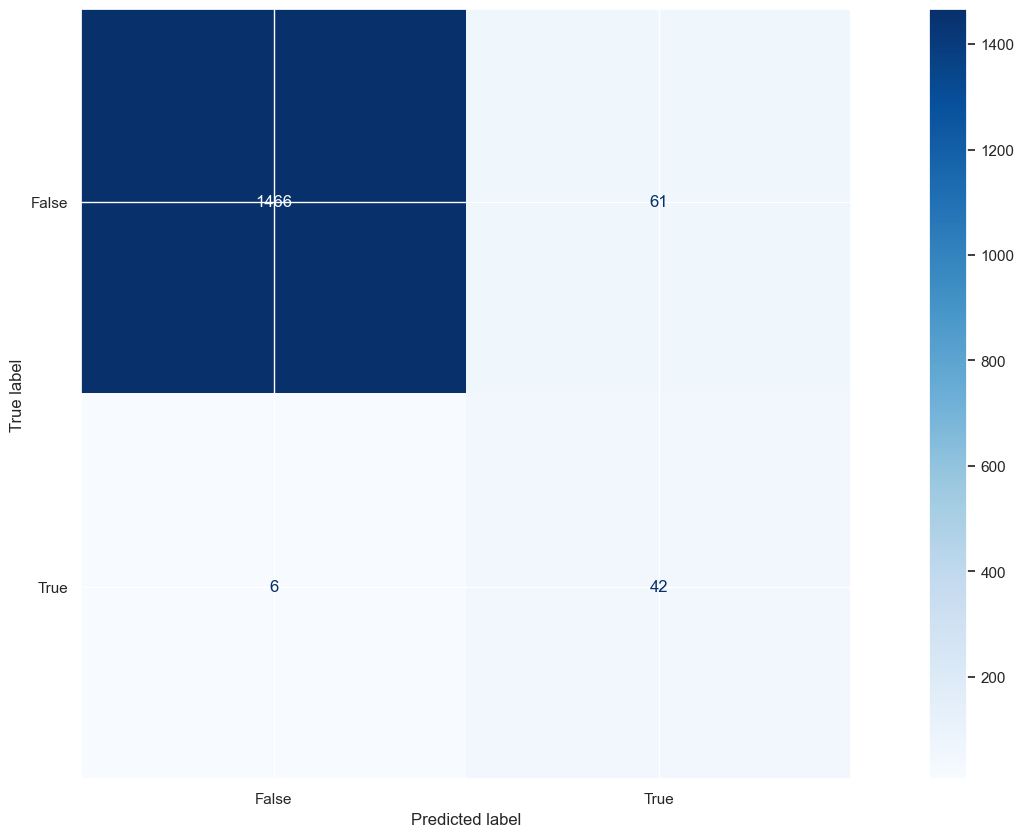

In [67]:
plot_model_info(
    model_best,
    X_test_cleaned,
    y_test,
)

# Step 8. Logistic Regression + CatBoost

In [70]:
# Get predictions from both models
cat_boost_preds = model_best.predict_proba(X_test_cleaned)[:, 1]
log_reg_preds = logreg_cv.predict_proba(test_pca)[:, 1]

# Average the predictions
# final_preds = np.mean([log_reg_preds, cat_boost_preds], axis=0)
preds = np.array([cat_boost_preds, log_reg_preds])
final_preds = np.average(preds, weights=[0.6, 0.4], axis=0)

# If you want to convert these to class predictions, you can do so like this:
final_class_preds = [1 if pred > 0.5 else 0 for pred in final_preds]

ROC-AUC score is:  0.900294695481336


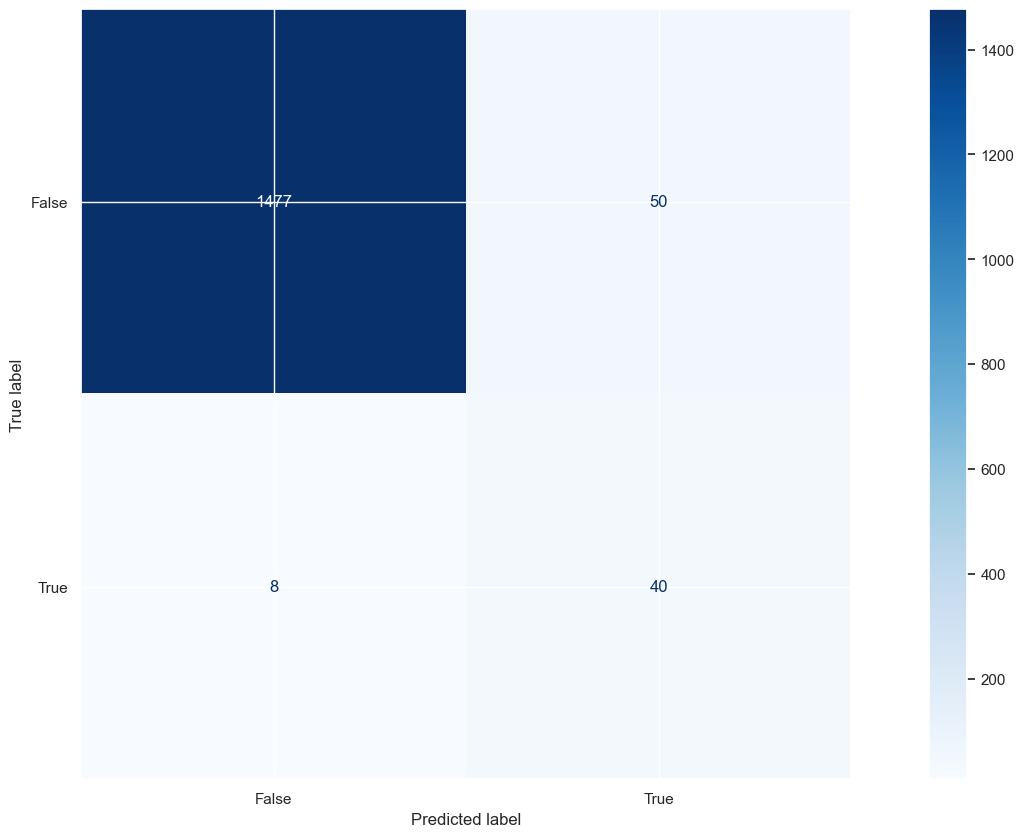

In [71]:
print("ROC-AUC score is: ", roc_auc_score(y_test, final_class_preds))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, final_class_preds), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

# Step 9. Prediction

In [72]:
X_lead_orig = pd.read_csv("../data/raw/train_dataset_Самолет.csv")
# X_lead = pd.read_csv('')
X_lead = create_date_features(X_lead_orig)
X_lead = X_lead[not_null_columns_names]
X_lead = X_lead.drop(columns=["target", "client_id", "report_date"])

categorical_columns = (
    X_lead
    .select_dtypes(exclude=["float64", "int64"])
    .columns
)
numerical_columns = (
    X_lead
    .select_dtypes(include=["float64", "int64"])
    .columns
)
X_lead[numerical_columns] = X_lead[numerical_columns].fillna(0)
X_lead[categorical_columns] = X_lead[categorical_columns].astype(str)
logger.info("DONE - Initial Preprocessing")


X_lead_cleaned = X_lead.iloc[:, useful_column_indices]
X_lead_linear = preprocessor.transform(X_lead_cleaned)
X_lead_pca = pca.transform(X_lead_linear)[:, :top_n]
logger.info("DONE - Data transformation for pca")

# Get predictions from both models
cat_boost_preds = model_best.predict_proba(X_lead_cleaned)[:, 1]
log_reg_preds = logreg_cv.predict_proba(X_lead_pca)[:, 1]
logger.info("DONE - Model predictions")

# Average the predictions
# final_preds = np.mean([log_reg_preds, cat_boost_preds], axis=0)
preds = np.array([cat_boost_preds, log_reg_preds])
final_preds = np.average(preds, weights=[0.6, 0.4], axis=0)

# If you want to convert these to class predictions, you can do so like this:
final_class_preds = [1 if pred > 0.5 else 0 for pred in final_preds]

2023-09-10 00:15:43,670 INFO DONE - Initial Preprocessing
2023-09-10 00:15:43,877 INFO DONE - Data transformation for pca
2023-09-10 00:15:43,917 INFO DONE - Model predictions


In [ ]:
# uncomment for leaderboard prediction
# X_lead_orig['target'] = final_class_preds